In [1]:
import numpy as np
import numpy.ma as ma
import random
import matplotlib as plt
from matplotlib.pyplot import figure
import seaborn as sns
from nim_env import NimEnv, OptimalPlayer

# Q-learning

In [2]:
class NimQlearningAgent:
    #Q learning agent for Nim with epsilon-greedy policy
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.2, player=0, Q=None):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player #  0 or 1
        a = np.zeros((8, 8, 8, 3, 7))
        if Q is not None:
            self.Q = Q
        else:
            for s1 in range(8):
                for s2 in range(8):
                    for s3 in range(8):
                        for a1 in range(3):
                            for a2 in range(7):
                                if a1 == 0:
                                    if a2 >= s1:
                                        a[s1, s2, s3, a1, a2] = np.NaN
                                elif a1 == 1:
                                    if a2 >= s2:
                                        a[s1, s2, s3, a1, a2] = np.NaN
                                else:
                                    if a2 >= s3:
                                        a[s1, s2, s3, a1, a2] = np.NaN
            self.Q = ma.masked_invalid(a)
    
    def randomMove(self, heaps):
        # the indexes of the heaps available are given by
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return move
        
    def act(self, heaps):
        if random.random() < self.epsilon:
            return self.randomMove(heaps)
        else:
            move = np.unravel_index(np.argmax(self.Q[heaps[0], heaps[1], heaps[2], :, :]), self.Q[heaps[0], heaps[1], heaps[2], :, :].shape)
            return [move[0] + 1, move[1] + 1]
        
    def update(self, oldHeaps, move, newHeaps, reward):
        if ((oldHeaps is not None) and (move is not None) and (newHeaps is not None)):
            oldQ = self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] - 1, move[1] -1]
            if newHeaps != [0,0,0]:
                self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] -1, move[1]-1] = oldQ + self.alpha *(reward + self.gamma * np.max(self.Q[newHeaps[0], newHeaps[1], newHeaps[2], :, :]) - oldQ)
            else:
                self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] -1, move[1]-1] = oldQ + self.alpha *(reward - oldQ)


In [3]:
env = NimEnv(seed = 10)

In [4]:
player_Q = NimQlearningAgent(player=0, epsilon=0.1)
player_opt = OptimalPlayer(epsilon=0.5, player=1)
reward_sum = 0
reward_sum2 = 0
avg_rewards = []
for i in range(20000):
    env.reset()
    lastActionState = None
    lastAction = None
    while not env.end:
        heaps, _, __ = env.observe()
        if env.current_player == player_opt.player:
            move = player_opt.act(heaps)
            newHeaps, end, winner = env.step(move)
        else:
            if (lastActionState is not None and lastAction is not None):
                reward = env.reward(player=player_Q.player)
                player_Q.update(lastActionState, lastAction, newHeaps, reward)
            lastActionState = heaps.copy()
            move = player_Q.act(heaps)
            lastAction = move
            newHeaps, end, winner = env.step(move)

        if end:
            reward = env.reward(player=player_Q.player)
            player_Q.update(lastActionState, lastAction, newHeaps, reward)
            reward_sum += reward
            reward_sum2 += reward
            if ((i+1) % 1000 == 0):
                print(reward_sum2 / (i+1))
            if ( (i+1) % 250 == 0):
                avg_rewards.append(reward_sum / 250)
                reward_sum = 0
            break
            
    player_Q.player = 1 - player_Q.player
    player_opt.player = 1 - player_opt.player

0.03
0.159
0.22466666666666665
0.282
0.2968
0.31466666666666665
0.32485714285714284
0.3385
0.3448888888888889
0.3562
0.3650909090909091
0.37516666666666665
0.38369230769230767
0.3884285714285714
0.3910666666666667
0.393875
0.39588235294117646
0.4003333333333333
0.402
0.4055


<AxesSubplot:>

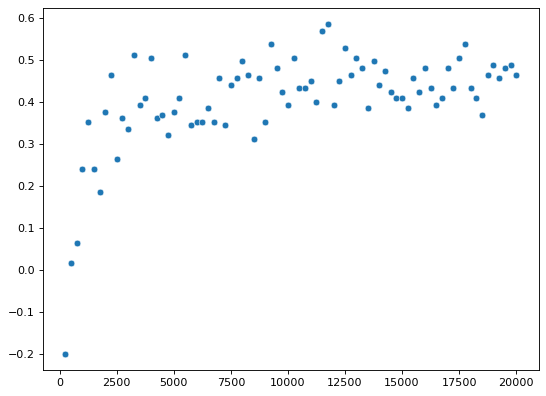

In [5]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=list(range(250, 20001, 250)), y=avg_rewards)